In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hasimsk","key":"4e63e26a37bf8a54a07f9a208400211f"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d 'stefanoleone992/imdb-extensive-dataset'
! mkdir imdb
! unzip imdb-extensive-dataset.zip -d imdb

 94% 77.0M/82.3M [00:00<00:00, 84.0MB/s]
100% 82.3M/82.3M [00:00<00:00, 93.9MB/s]
Archive:  imdb-extensive-dataset.zip
  inflating: imdb/IMDb movies.csv    
  inflating: imdb/IMDb names.csv     
  inflating: imdb/IMDb ratings.csv   
  inflating: imdb/IMDb title_principals.csv  


In [4]:
%%capture
import nltk
nltk.download('stopwords')
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
! pip install plotly==4.14.3
import plotly.express as px
import matplotlib.pyplot as plt
! sudo apt install openjdk-8-jdk
! sudo update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
! pip install language-check
! pip install pycontractions
from pycontractions import Contractions
cont=Contractions(api_key="glove-twitter-25")
cont.load_models()

In [5]:
# reading the movies data
movies=pd.read_csv('imdb/IMDb movies.csv')
movies.head(2)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0


In [6]:
print('Data shape: ',movies.shape,'\n')
movies.columns

Data shape:  (85855, 22) 



Index(['imdb_title_id', 'title', 'original_title', 'year', 'date_published',
       'genre', 'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics'],
      dtype='object')

In [7]:
# getting those columns that are going to be useful in this project.
useful_columns=['imdb_title_id','title','date_published','genre','language','duration','country','director','production_company','actors','description']
movies=movies[useful_columns].copy()

In [8]:
movies.isna().sum()

imdb_title_id            0
title                    0
date_published           0
genre                    0
language               833
duration                 0
country                 64
director                87
production_company    4455
actors                  69
description           2115
dtype: int64

In [9]:
movies.fillna('unknown',inplace=True)

In [10]:
# converting date_published column to datetime type from onject type
idx=movies[movies['date_published']=='TV Movie 2019'].index
movies.loc[idx,'date_published']='2019'
movies['date_published']=pd.to_datetime(movies['date_published'])
movies['primary_genre']=movies['genre'].apply(lambda x: x.split(',')[0])
movies['primary_language']=movies['language'].apply(lambda x: x.split(',')[0])
movies['primary_country']=movies['country'].apply(lambda x: x.split(',')[0])

In [11]:
px.sunburst(movies,path=['primary_country','primary_language','primary_genre'], 
            height=700,width=700,title='No. of Movies in Each Language by Genre')

In [12]:
def visualise_plot_plt():  
  plt.style.use('ggplot')
  plt.figure(figsize=(20,50))
  for num,var in enumerate(base_categ):

    plt.subplot(len(base_categ),2,2*num+1)
    movies[var].value_counts()[:15].plot(kind='pie',autopct='%1.1f%%',explode=np.ones(15)*0.1,rotatelabels=True,radius=0.8,shadow=True)
    plt.title("Number of Movies by {}".format(var.capitalize()),weight='bold')
    plt.tick_params(labelsize='x-large')
    plt.axis('off')

    plt.subplot(len(base_categ),2,2*(num+1))
    movies[var].value_counts()[:15].plot(kind='bar',color='y',edgecolor='r',linewidth=3)
    plt.grid(True)
    plt.tick_params(grid_color='r',grid_linestyle='-.')

    plt.title("Number of Movies by {}".format(var.capitalize()),weight='bold')
    for k,val in enumerate(movies[var].value_counts()[:15]):
      plt.text(x=k-0.33,y=val*1.02,s=val,weight='bold')

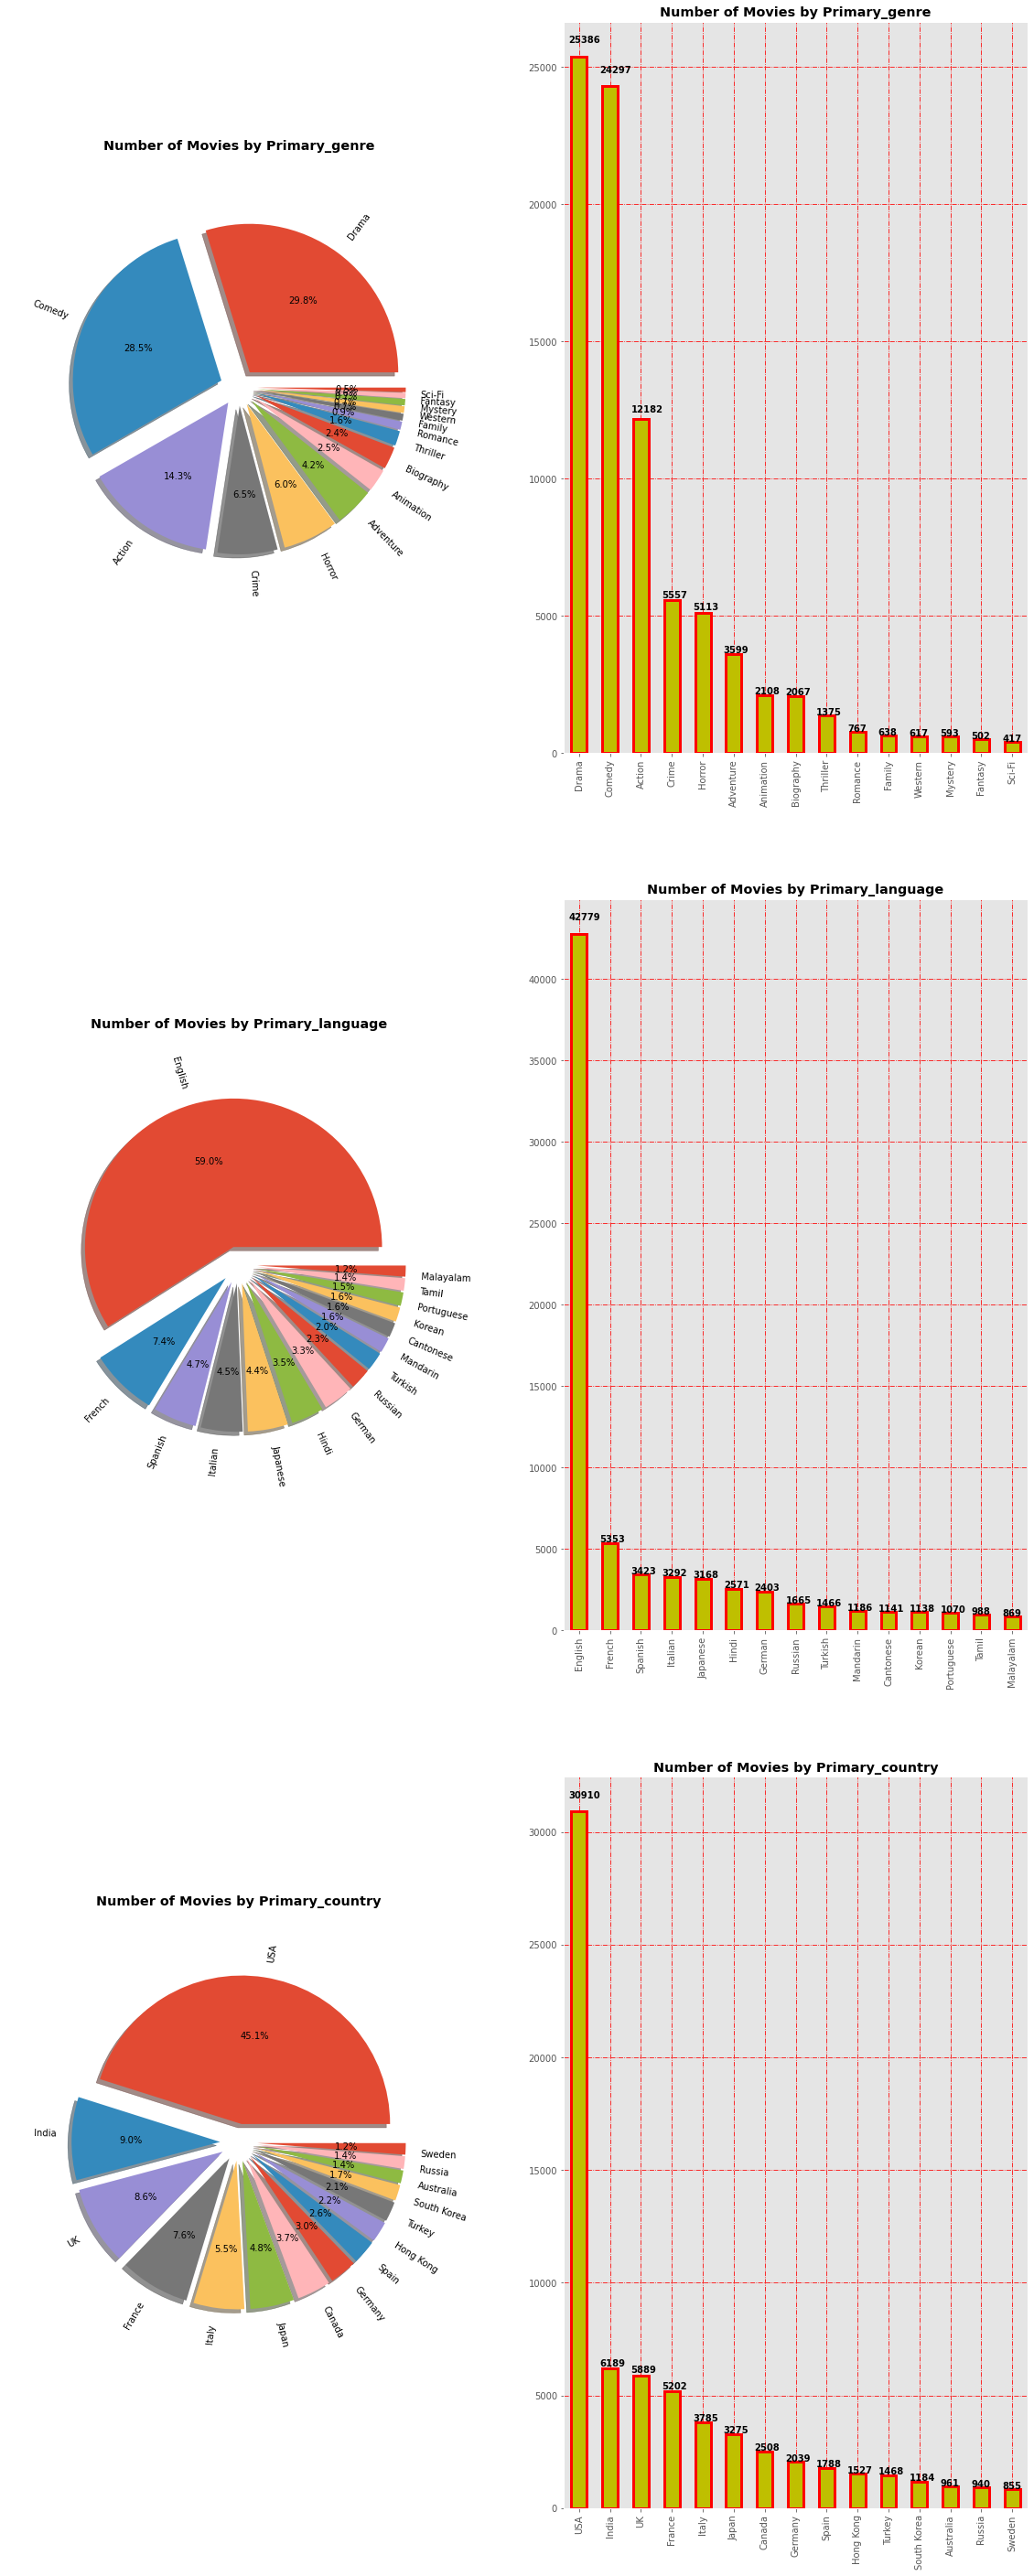

In [13]:
base_categ=['primary_genre','primary_language','primary_country']
visualise_plot_plt()

In [14]:
# getting only Indian movies.
movies=movies[movies['primary_country']=='India']
movies.reset_index(drop=True, inplace=True)
print('new movies data shape: ',movies.shape)
movies.sample(3)

new movies data shape:  (6189, 14)


,imdb_title_id,title,date_published,genre,language,duration,country,director,production_company,actors,description,primary_genre,primary_language,primary_country
441,tt0106204,Aankhen,1993-01-01,"Action, Comedy, Crime",Hindi,170,India,David Dhawan,Chiragdeep International,"Govinda, Chunky Pandey, Raj Babbar, Kader Khan...",Two good-for-nothing brothers are embroiled in...,Action,Hindi,India
1094,tt0248673,Aparan,1988-01-01,"Mystery, Thriller",Malayalam,115,India,P. Padmarajan,unknown,"Jayaram, Shobana, Madhu, Sukumari, Mukesh, M.G...","Viswanathan, new in town, soon learns that he ...",Mystery,Malayalam,India
1090,tt0248497,Suswagatham,1997-01-01,"Drama, Romance",Telugu,151,India,Srinivasa Rao Bhimaneni,Super Good Combines,"Devayani, Pawan Kalyan, Raghuvaran, Prakash Ra...","Ganesh loves Sandhya obsessively , but she is ...",Drama,Telugu,India


In [15]:
px.sunburst(movies,path=['primary_country','primary_language','primary_genre'], 
            height=700,width=700,title='No. of Movies in Each Language by Genre')

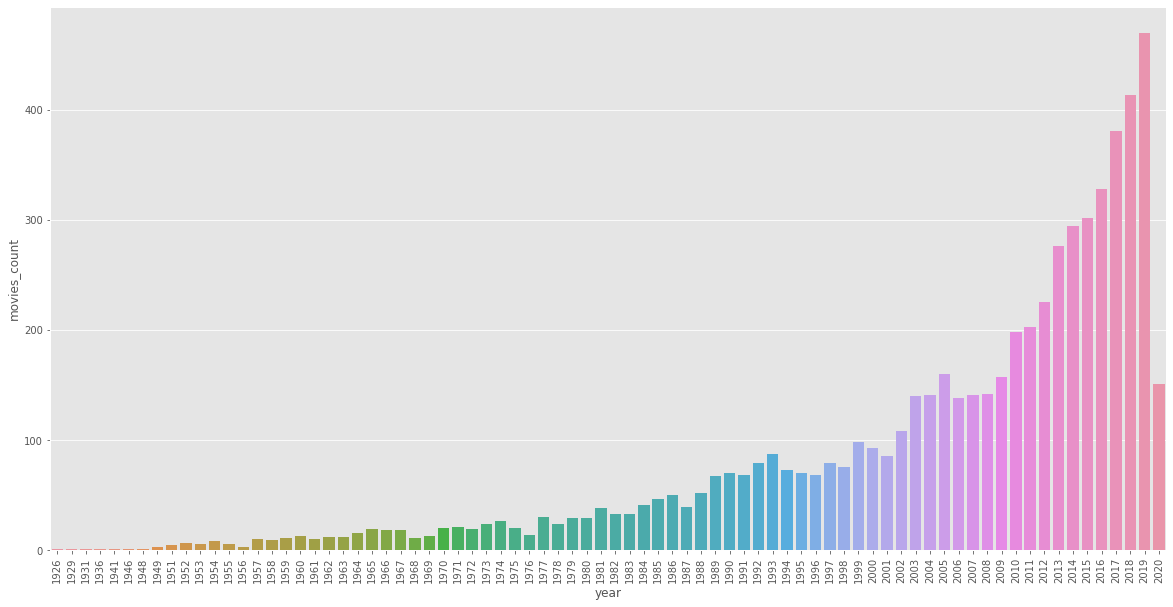

In [16]:
# adding an extra column named year so we can visualize how many movies are released per year.
movies['year']=movies['date_published'].dt.year
yearly_grpd=movies.groupby('year').count().reset_index()
yearly_grpd=yearly_grpd[['year','imdb_title_id']]
yearly_grpd.columns=['year','movies_count']
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.figure(1,(20,10))
plt.xticks(rotation=90)
sns.barplot(x='year',y='movies_count',data=yearly_grpd)
plt.show()

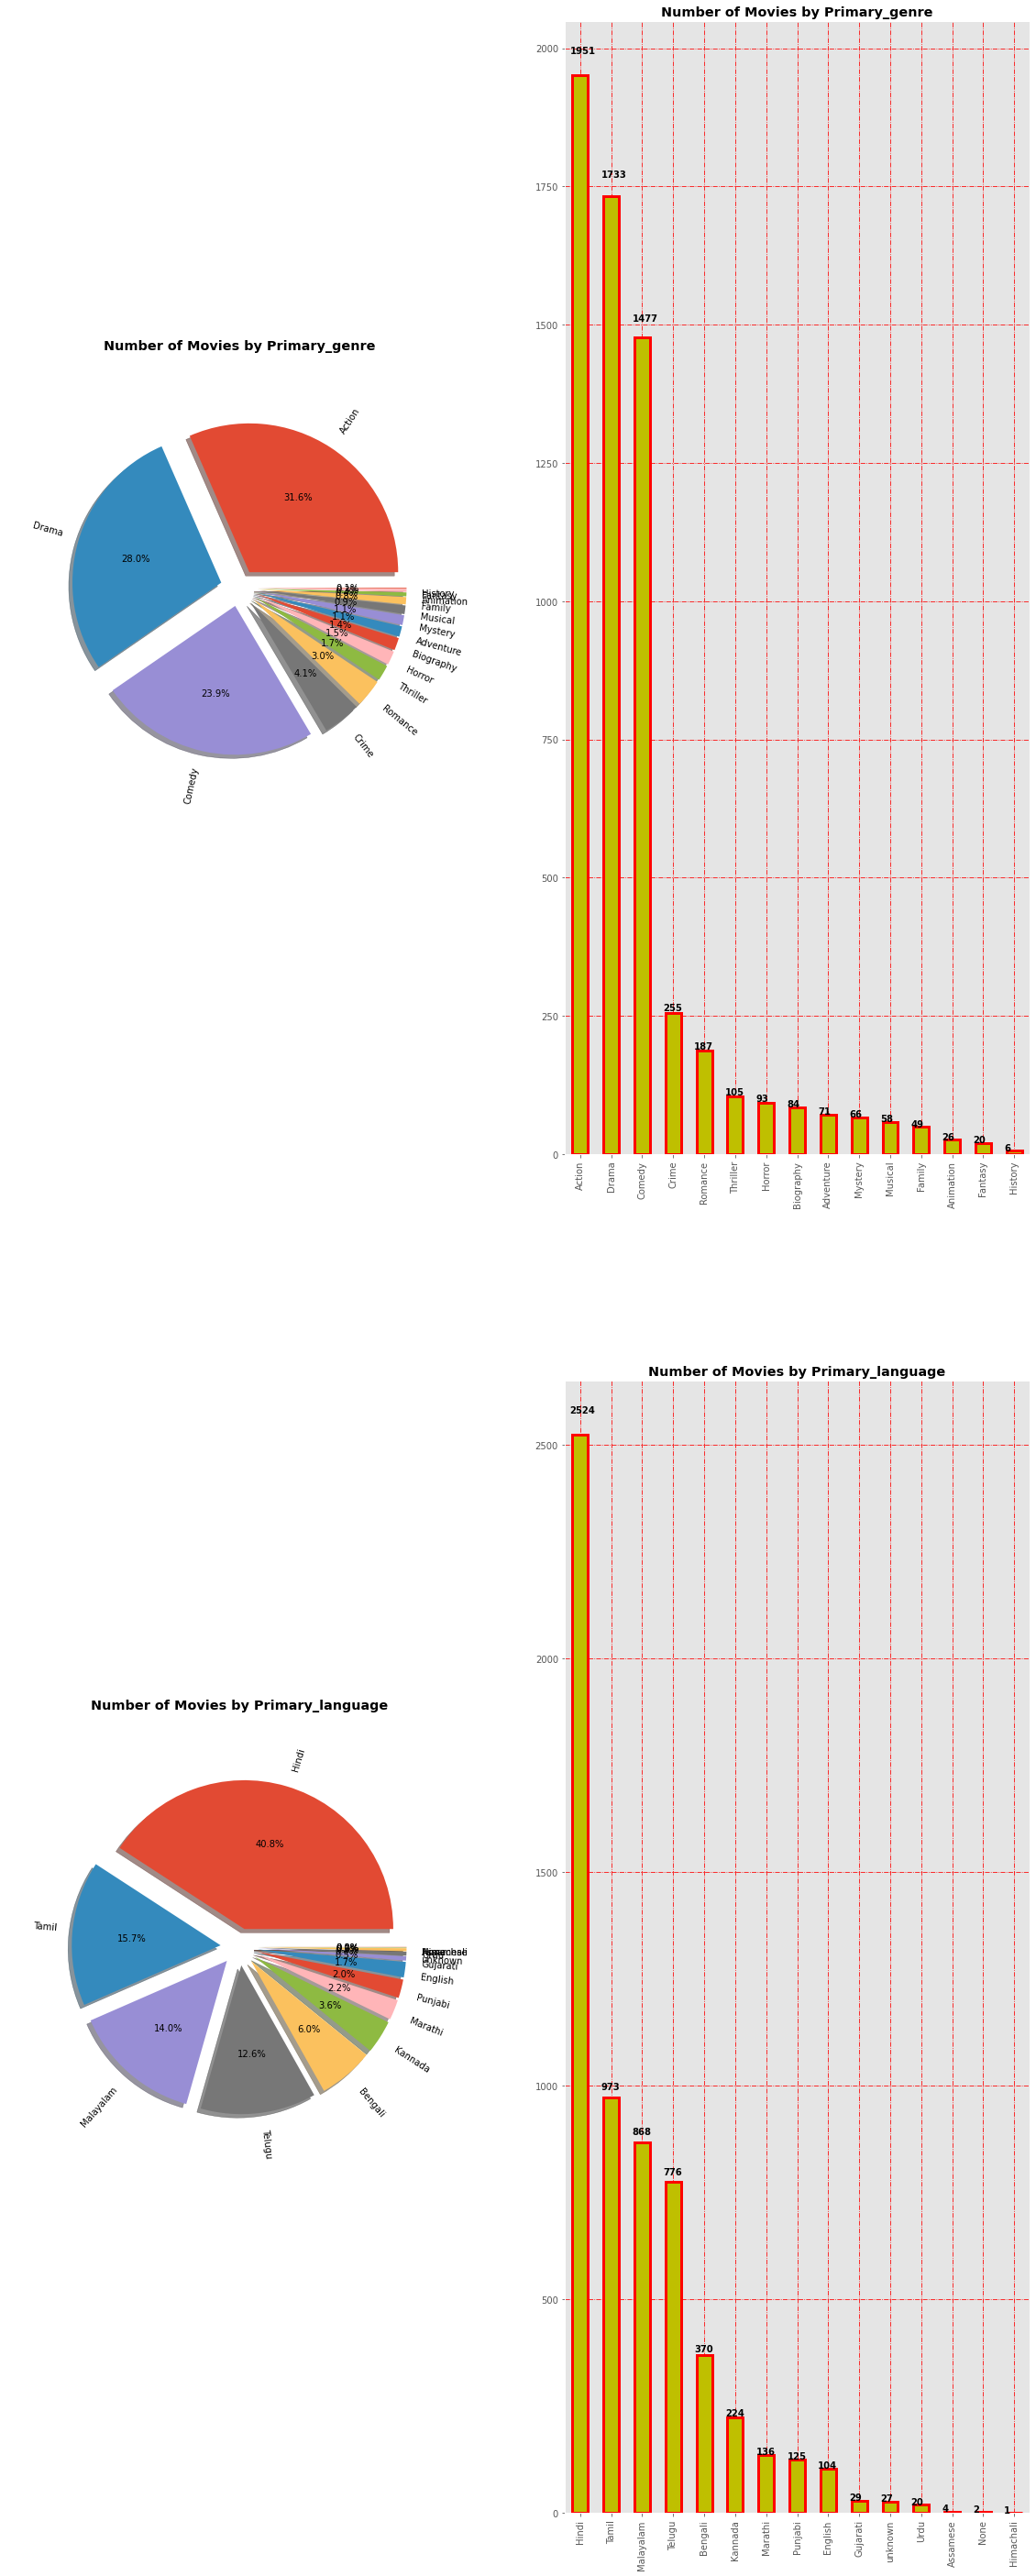

In [17]:
base_categ=['primary_genre','primary_language']
visualise_plot_plt()

In [18]:
def discard_stopwords(text):
  if pd.isna(text):
    text=' '
  try:
    text=text.lower()
    text=text.replace(':','')
    text=text.replace('-',' ')
    text=text.replace(';','')
    text=text.replace('!','')
    text=text.replace(',','')
    text=text.replace('"','')
    text=text.replace('.','')
    text=text.replace('(','')
    text=text.replace(')','')
    text=list(cont.expand_texts([text],precise=True))[0]
    text=text.split()
    text=[word for word in text if word not in stopwords.words('english')]
    text=' '.join(text)
    return text
  except:
    print('ERROR: ',text)

In [19]:
def discard_punc(text):
  text=text.lower()
  text=text.replace('.','')
  text=text.replace('+','')
  text=text.replace('=','')
  text=text.replace('!','')
  text=text.replace(':','')
  text=text.replace('-','')
  text=text.replace('?','')
  text=text.replace(',','')
  text=text.replace("'",'')
  return text

In [20]:
col=['imdb_title_id','title','genre','director','actors','description']
df=movies[col].copy()

df['description']=df['description'].apply(discard_stopwords)
df['title']=df['title'].apply(discard_punc)
df['actors']=df['actors'].apply(discard_punc)
df['director']=df['director'].apply(discard_punc)
df['genre']=df['genre'].apply(discard_punc)

In [21]:
new_feature=[]
for item in df.itertuples():
  new_feature.append(item[2]+' '+item[3]+' '+item[4]+' '+item[5]+' '+item[6])
df['new_feature']=new_feature
#df['new_feature']=df['new_feature'].apply(lambda x: x.replace(',',''))
df.head(2)

,imdb_title_id,title,genre,director,actors,description,new_feature
0,tt0016240,prem sanyas,drama,franz osten himanshu rai,seeta devi himanshu rai sarada ukil ranibala p...,adaptation arnold's 1861 orientalist epic open...,prem sanyas drama franz osten himanshu rai see...
1,tt0019374,shiraz,drama history romance,franz osten,himanshu rai charu roy seeta devi enakashi ram...,historical romance set mughal empire selima en...,shiraz drama history romance franz osten himan...


In [22]:
cm=CountVectorizer().fit_transform(df['new_feature'])
print(cm.shape)

(6189, 32293)


In [23]:
cs=cosine_similarity(cm)
del cm
cs.shape

(6189, 6189)

In [24]:
cs_df=pd.DataFrame(cs,columns=df['imdb_title_id'].values)
del cs
cs_df.set_index(df['imdb_title_id'].values,inplace=True)
cs_df.head(2)

,tt0016240,tt0019374,tt0021594,tt0027256,tt0028217,tt0040067,tt0041123,tt0041161,tt0041619,tt0043306,tt0043307,tt0043908,tt0044318,tt0044392,tt0044527,tt0044761,tt0044778,tt0044952,tt0045467,tt0045693,tt0046164,tt0046304,tt0046673,tt0046703,tt0046799,tt0047561,tt0047990,tt0048392,tt0048473,tt0048613,tt0048956,tt0049041,tt0049072,tt0049378,tt0049393,tt0050188,tt0050322,tt0050484,tt0050665,tt0050757,...,tt9648672,tt9664732,tt9665400,tt9665402,tt9670480,tt9675464,tt9675716,tt9680136,tt9680166,tt9680180,tt9691336,tt9740272,tt9742334,tt9742362,tt9760512,tt9760934,tt9766160,tt9766280,tt9766310,tt9769714,tt9789440,tt9789670,tt9793334,tt9799984,tt9808564,tt9817300,tt9817760,tt9834062,tt9877340,tt9878242,tt9883042,tt9886872,tt9890308,tt9894098,tt9900782,tt9903716,tt9905412,tt9905462,tt9906644,tt9911774
tt0016240,1.000000,0.329926,0.019627,0.115172,0.0,0.036460,0.018598,0.033338,0.040177,0.031810,0.018791,0.089414,0.036460,0.058222,0.018990,0.0,0.100443,0.053648,0.018411,0.157992,0.112747,0.102568,0.000000,0.056373,0.018598,0.000000,0.034794,0.000000,0.194138,0.037980,0.089414,0.0,0.000000,0.070219,0.068379,0.018990,0.067797,0.092992,0.056970,0.000000,...,0.056373,0.018411,0.021119,0.016274,0.000000,0.000000,0.018990,0.017716,0.021698,0.025055,0.033338,0.016274,0.0,0.0,0.00000,0.0,0.017397,0.018054,0.018411,0.026575,0.01823,0.017716,0.0,0.000000,0.000000,0.022327,0.032050,0.039707,0.018990,0.041694,0.000000,0.000000,0.018598,0.000000,0.0,0.000000,0.020089,0.053149,0.017883,0.034794
tt0019374,0.329926,1.000000,0.022473,0.175835,0.0,0.041748,0.063888,0.057260,0.115011,0.054636,0.043033,0.184289,0.062622,0.111111,0.108721,0.0,0.092009,0.020477,0.063246,0.180907,0.193649,0.078296,0.044947,0.129099,0.063888,0.039841,0.139443,0.041748,0.170996,0.043489,0.061430,0.0,0.046562,0.080403,0.019574,0.065233,0.058222,0.127775,0.043489,0.043489,...,0.021517,0.000000,0.024183,0.055902,0.020286,0.021296,0.065233,0.060858,0.024845,0.028689,0.114520,0.000000,0.0,0.0,0.02387,0.0,0.019920,0.020672,0.021082,0.060858,0.00000,0.060858,0.0,0.021979,0.035635,0.025565,0.055048,0.022733,0.086977,0.071611,0.020286,0.055902,0.021296,0.022733,0.0,0.037268,0.046004,0.020286,0.020477,0.039841


In [25]:
# takes first column then sorts it in descending manner then taking the index of them which is the movie_id
cs_df_sorted=cs_df.apply(lambda x: x.sort_values(ascending=False).index)
cs_df_sorted=cs_df_sorted.iloc[1:11,]
cs_df_sorted.reset_index(drop=True,inplace=True)

In [61]:
import pickle
with open('data.pkl','wb') as pkl_file:
  pickle.dump(cs_df_sorted, pkl_file, protocol=4)

In [59]:
with open('data.pkl','rb') as pkl_file:
  new_data=pickle.load(pkl_file)
type(new_data)

pandas.core.frame.DataFrame

In [52]:
def get_recommendation(movie_name):
  id_=movies[movies['title']==movie_name]['imdb_title_id'].values[0]
  title_id=new_data[id_].values
  for i in title_id:
    print(movies[movies['imdb_title_id']==i]['title'].values[0]) 


In [62]:
get_recommendation('Main Hoon Na')

Felice anno nuovo
Om Shanti Om
Heyy Babyy
Josh
Hello Brother
Paheli
Kabhi Haan Kabhi Naa
Sarfarosh
Janasheen
Yun Hota Toh Kya Hota


In [41]:
get_recommendation('Manoharam')

Kunjiramayanam
Oru Muthassi Gadha
Love Action Drama
Thattathin Marayathu
Ohm Shanthi Oshaana
The Great Father
O.P.160/18 Kakshi: Amminippilla
Godha
Ustad Hotel
Gauthamante Radham


In [60]:
get_recommendation('Don 2')

Don
Felice anno nuovo
Josh
Main Hoon Na
Qurbani
Hello Brother
Janasheen
Om Shanti Om
Fool N Final
Billu


In [63]:
get_recommendation('Abhimanyu')

Kilichundan Mampazham
Chithram
Vismayathumbathu
Vandanam
Vatsalyam
Devadoothan
Kakkakuyil
Manoranjan
Thalavattam
Hitler


In [64]:
get_recommendation('Anantaram')

Mathilukal
Thinkalazhcha Nalla Divasam
Ulladakkam
Rathinirvedam
Hitler
Elippathayam
Nizhalkkuthu
Golanthara Vartha
Arappatta Kettiya Graamathil
Yaathra


In [39]:
movies[movies['primary_language']=='Malayalam']

,imdb_title_id,title,date_published,genre,language,duration,country,director,production_company,actors,description,primary_genre,primary_language,primary_country,year
96,tt0059028,Chemmeen,1965-08-19,"Drama, Romance","Malayalam, Hindi",140,India,Ramu Kariat,Kanmani Films,"Sathyan, Sheela, Madhu, Kottarakkara Sridharan...","Karutthamma, the daughter of a Hindu fisherman...",Drama,Malayalam,India,1965
251,tt0082318,Elippathayam,1982-05-01,Drama,Malayalam,121,India,Adoor Gopalakrishnan,General Pictures,"Jalaja, Karamana Janardanan Nair, Rajam K. Nai...",The protagonist is trapped within himself and ...,Drama,Malayalam,India,1982
317,tt0090634,Amma Ariyan,1987-01-01,Drama,Malayalam,115,India,John Abraham,Odessa Movies,"Kunhulakshmi Amma, Nilambur Balan, Harinarayan...",The story revolves around the incidents follow...,Drama,Malayalam,India,1987
327,tt0092507,Abhimanyu,1991-01-01,"Crime, Drama, Musical","Malayalam, Hindi",140,India,Priyadarshan,unknown,"Mohanlal, Shanker, Geetha, Cochin Hanifa, Jaga...",A daily-wage welder from Bombay's red light di...,Crime,Malayalam,India,1991
328,tt0092557,Anantaram,1987-10-01,Drama,Malayalam,125,India,Adoor Gopalakrishnan,General Pictures,"Mammootty, Asokan, Shobana, Bahadur, Vembayam ...",The film develops through a commentary by Ajay...,Drama,Malayalam,India,1987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6180,tt9886872,Munthiri Monchan,2019-12-06,"Comedy, Romance",Malayalam,130,India,Vijith Nambiar,Vishvas Movies,"Manesh Krishnan, Gopika Anil, Salim Kumar, Dev...",Munthiri Monchan is a feel good urban romantic...,Comedy,Malayalam,India,2019
6185,tt9905412,Ottam,2019-03-08,Drama,Malayalam,120,India,Zam,Thomas Thiruvalla Films,"Nandu Anand, Roshan Ullas, Manikandan R. Achar...","Set in Trivandrum, the story of Ottam unfolds ...",Drama,Malayalam,India,2019
6186,tt9905462,Pengalila,2019-03-08,Drama,Malayalam,111,India,T.V. Chandran,Benzy Productions,"Lal, Akshara Kishor, Iniya, Narain, Renji Pani...",An unusual bond between a sixty year old Dalit...,Drama,Malayalam,India,2019
6187,tt9906644,Manoharam,2019-09-27,"Comedy, Drama",Malayalam,122,India,Anvar Sadik,chakkalakal Films,"Vineeth Sreenivasan, Aparna Das, Basil Joseph,...",Manoharan is a poster artist struggling to fin...,Comedy,Malayalam,India,2019
